In [1]:
import os
import torch
import torchmetrics
import torch.nn.functional as F

from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

#import pytorch_lightning as pl
#from pytorch_lightning.loggers import TensorBoardLogger
import lightning as L
#from pytorch_lightning.loggers import TensorBoardLogger
from lightning.pytorch.loggers import TensorBoardLogger

from PIL import Image

c:\Users\indtal\AppData\Local\anaconda3\envs\deepLearning\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [3]:
class Dataset():
    def __init__(self, filelist, filepath, transform=None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))
    
    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)


# Set directory paths for our files
train_dir = 'cats_vs_dogs/train'
test_dir = 'cats_vs_dogs/test1'

# Get files in our directories
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

# Create our transforms
"""transformations = {
    'train': transforms.Compose([transforms.Resize((60,60)),
                                      transforms.RandomAffine(degrees = 10, translate = (0.05,0.05), shear = 5), 
                                      transforms.ColorJitter(hue = .05, saturation = .05),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(15),
                                      transforms.ToTensor(),
                                      transforms.Normalize(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}"""
transformations = transforms.Compose([transforms.Resize((60,60)),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Create our train and test dataset objects
train = Dataset(train_files, train_dir, transformations)
val = Dataset(test_files, test_dir, transformations)

# Split into our train and validation
train, val = torch.utils.data.random_split(train,[20000,5000]) 

#train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)
#val_loader = torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

In [5]:
print(train[0])

(tensor([[[-0.0510, -0.2706, -0.1843,  ..., -0.4118, -0.4039, -0.4039],
         [ 0.2627,  0.1608, -0.2314,  ..., -0.3412, -0.4039, -0.4588],
         [-0.1059, -0.0510, -0.1843,  ..., -0.3725, -0.4510, -0.4588],
         ...,
         [ 0.4510,  0.5686,  0.7255,  ...,  0.8039,  0.8431,  0.8431],
         [ 0.8588,  0.8039,  0.6941,  ...,  0.6314,  0.7098,  0.8118],
         [ 0.6863,  0.5294,  0.4667,  ...,  0.4902,  0.4745,  0.6314]],

        [[ 0.0431, -0.1765, -0.0980,  ..., -0.3255, -0.2941, -0.3020],
         [ 0.3569,  0.2549, -0.1373,  ..., -0.3098, -0.3098, -0.3569],
         [-0.0039,  0.0275, -0.1294,  ..., -0.3804, -0.4039, -0.4039],
         ...,
         [ 0.6627,  0.7255,  0.8431,  ...,  0.9216,  0.9137,  0.9137],
         [ 0.9373,  0.9137,  0.7804,  ...,  0.8039,  0.8510,  0.8902],
         [ 0.7882,  0.7255,  0.6627,  ...,  0.7804,  0.7725,  0.8588]],

        [[-0.0588, -0.2863, -0.2078,  ..., -0.4824, -0.4510, -0.4431],
         [ 0.2784,  0.1529, -0.2784,  ..., -

In [6]:
print(f'Number of images in {train_dir} is {len(train_files)}')
print(f'Number of images in {test_dir} is {len(test_files)}')

Number of images in cats_vs_dogs/train is 25000
Number of images in cats_vs_dogs/test1 is 12500


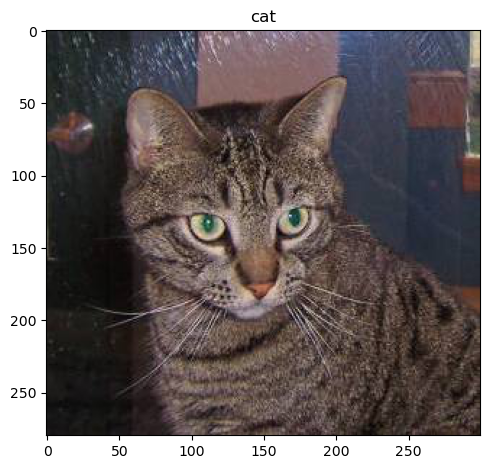

In [7]:
import cv2
import matplotlib.pyplot as plt
def imgshow(title, image = None, size =6):
    w,h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size*aspect_ratio, size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

# Display a image
img = cv2.imread("cats_vs_dogs/train/"+train_files[1])
imgshow("cat",img)


## **2. Organzing our code into the Lightning structure/design philosophy**

In [8]:
from typing import Any
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS


class LitModel(L.LightningModule):
    def __init__(self, learning_rate, batch_size):
        super().__init__()
        self.learning_rate = learning_rate
        self.batch_size = batch_size
       # self.accuracy = torchmetrics.Accuracy() 
       # self.train_acc = torchmetrics.Accuracy() 
       # self.valid_acc = torchmetrics.Accuracy() 
        self.conv1 = nn.Sequential(nn.Conv2d(3,16,3), nn.ReLU(), nn.MaxPool2d(2,2)) 
        self.conv2 = nn.Sequential(nn.Conv2d(16,32,3), nn.ReLU(), nn.MaxPool2d(2,2)) 
        self.conv3 = nn.Sequential(nn.Conv2d(32,64,3), nn.ReLU(), nn.MaxPool2d(2,2)) 
        self.fc1 = nn.Sequential(nn.Flatten(), nn.Linear(64*5*5,256), nn.ReLU(), nn.Linear(256,128), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(128,2),)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)
    
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)
    
    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self.forward(data)
        loss = nn.CrossEntropyLoss()(output, label)
        self.log('train_loss',loss)
        return {'loss': loss, 'log': self.log}
    
    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_out = self.forward(val_data)
        val_loss = nn.CrossEntropyLoss()(val_out, val_label)
        self.log('val_loss', val_loss)


    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim = 1) 

In [9]:
# Automatic Batch Size selection

model = LitModel(0.02, batch_size=32)
trainer = L.Trainer()
tuner = L.pytorch.tuner.Tuner(trainer)
tuner.scale_batch_size(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\indtal\AppData\Local\anaconda3\envs\deepLearning\Lib\site-packages\lightning\pytorch\loops\utilities.py:72: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
c:\Users\indtal\AppData\Local\anaconda3\envs\deepLearning\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\indtal\AppData\Local\anaconda3\envs\deepLearning\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438: PossibleUserWarning: The data

32768

In [10]:
model = LitModel(batch_size=32, learning_rate=0.001)
trainer = L.Trainer()
tuner = L.pytorch.tuner.Tuner(trainer)
tuner.lr_find(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\indtal\AppData\Local\anaconda3\envs\deepLearning\Lib\site-packages\lightning\pytorch\loops\utilities.py:72: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at c:\Users\indtal\OneDrive - Vanderlande\Desktop\Misc\other laptop data\All or Nothing\Deep Learning\Code & Models\.lr_find_958d4e92-ff16-42ef-a726-5af96a4865e9.ckpt
Restored all states from the checkpoint at c:\Users\indtal\OneDrive - Vanderlande\Desktop\Misc\other laptop data\All or Nothing\Deep Learning\Code & Models\.lr_find_958d4e92-ff16-42ef-a726-5af96a4865e9.ckpt


In [13]:
model = LitModel(batch_size=32, learning_rate=0.00063095)
trainer = L.Trainer(limit_train_batches=100, max_epochs=5)
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 448   
1 | conv2 | Sequential | 4.6 K 
2 | conv3 | Sequential | 18.5 K
3 | fc1   | Sequential | 442 K 
4 | fc2   | Sequential | 258   
-------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [14]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
An attempt was made to access a socket in a way forbidden by its access permissions

In [17]:
# Model Checkpoint

from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint

early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    strict = False,
    verbose = False,
    mode = 'min'
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='models/',
    filename='sample-catsvsdogs-{epoch:02d}-{val_loss:.2f}',
    save_top_k = 3,
    mode = 'min'
)

In [23]:
# We can even use some custom callbacks
import lightning.pytorch as pl
class MyPrintingCallback(pl.Callback):

    def on_init_start(self, trainer):
        print('Starting to init trainer!')

    def on_init_end(self, trainer):
        print('trainer is init now')

    def on_train_end(self, trainer, pl_module):
        print('do something when training ends')

In [24]:
# Train with Callbacks

model = LitModel(batch_size=32, learning_rate=0.00063095)
trainer = L.Trainer(limit_train_batches=100, max_epochs=8, callbacks=[early_stop, checkpoint_callback, MyPrintingCallback()])
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 448   
1 | conv2 | Sequential | 4.6 K 
2 | conv3 | Sequential | 18.5 K
3 | fc1   | Sequential | 442 K 
4 | fc2   | Sequential | 258   
-------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\indtal\AppData\Local\anaconda3\envs\deepLearning\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\indtal\AppData\Local\anaconda3\envs\deepLearning\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

do something when training ends


In [25]:
checkpoint_callback.best_model_path

'C:\\Users\\indtal\\OneDrive - Vanderlande\\Desktop\\Misc\\other laptop data\\All or Nothing\\Deep Learning\\Code & Models\\models\\sample-catsvsdogs-epoch=00-val_loss=0.31.ckpt'

In [26]:
pretrained_model = LitModel.load_from_checkpoint(batch_size = 32, learning_rate=0.00063095, checkpoint_path = checkpoint_callback.best_model_path)
pretrained_model = pretrained_model.to("cpu")
pretrained_model.eval()
pretrained_model.freeze()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

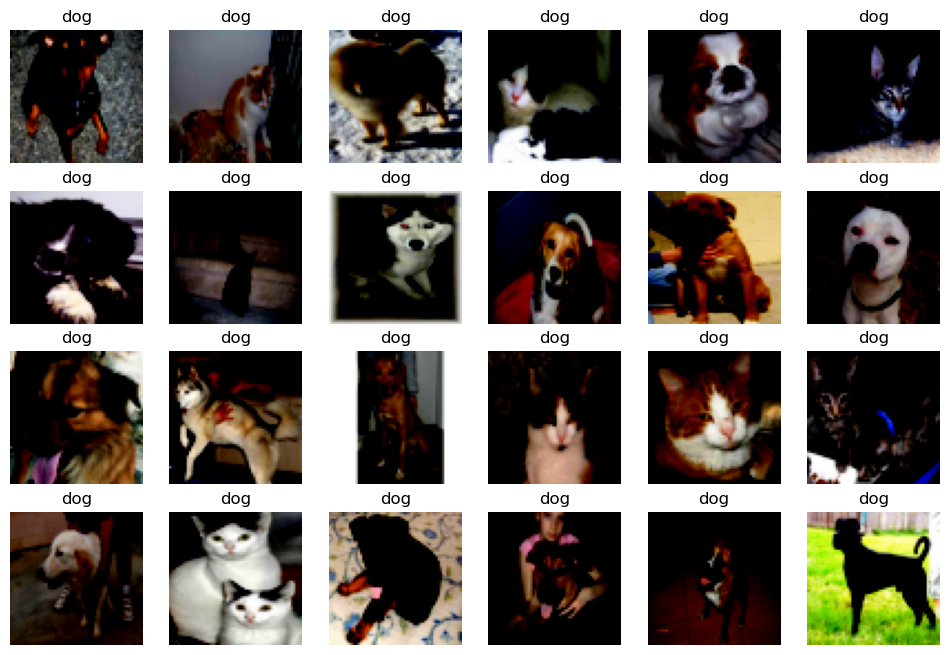

In [38]:
#samples, _ = iter(model.val_dataloader()).next()
#samples, g = iter(val)
#samples = samples.to('cpu')
import numpy as np
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)
dataiter = iter(val_loader)
samples, labels = next(dataiter)

fig = plt.figure(figsize=(12, 8))
fig.tight_layout()

output = pretrained_model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))